---
# **1. Example 4 dim**
---
### **1.1. Likelihood function and prior distribution**

The first step in any analysis is to define the prior distribution and likelihood function. More precisely, for computational reasons, we require the logarithm of the prior probability density function **log prior(θ) = log p(θ)** and the logarithm of the likelihood function **log L(θ) = log P(d|θ)**


In [12]:
import numpy as np
from scipy.stats import uniform, norm
import pocomc as pc

# Set the random seed.
np.random.seed(0)
# Define the dimensionality of our problem.
n_dim = 10

# Define our 10-D Rosenbrock log-likelihood.
def log_likelihood(x):
    return -np.sum(10.0 * (x[:, ::2] ** 2.0 - x[:, 1::2]) ** 2.0 + (x[:, ::2] - 1.0) ** 2.0, axis=1)

# Define our normal/Gaussian prior.
prior = pc.Prior(n_dim*[norm(0.0, 3.0)]) # N(0,3)

### **1.2. Preconditioned Monte Carlo sampling**

The next step is to initialise the PMC sampler using pocoMC and configure it for our analysis.

In [ ]:
# Initialise sampler
sampler = pc.Sampler(
    prior=prior,
    likelihood=log_likelihood,
    vectorize=True,
    random_state=0
)

# Start sampling
sampler.run()

Iter: 39it [04:00,  6.16s/it, beta=1, calls=76032, ESS=4003, logZ=-21.1, logP=-25.2, acc=0.569, steps=12, eff=1]       


### **1.3. Posterior samples**

We can get the weighted posterior samples (along with their log-likelihood and log-prior values) using the posterior() method and then plot their 1D and 2D marginal distributions using corner

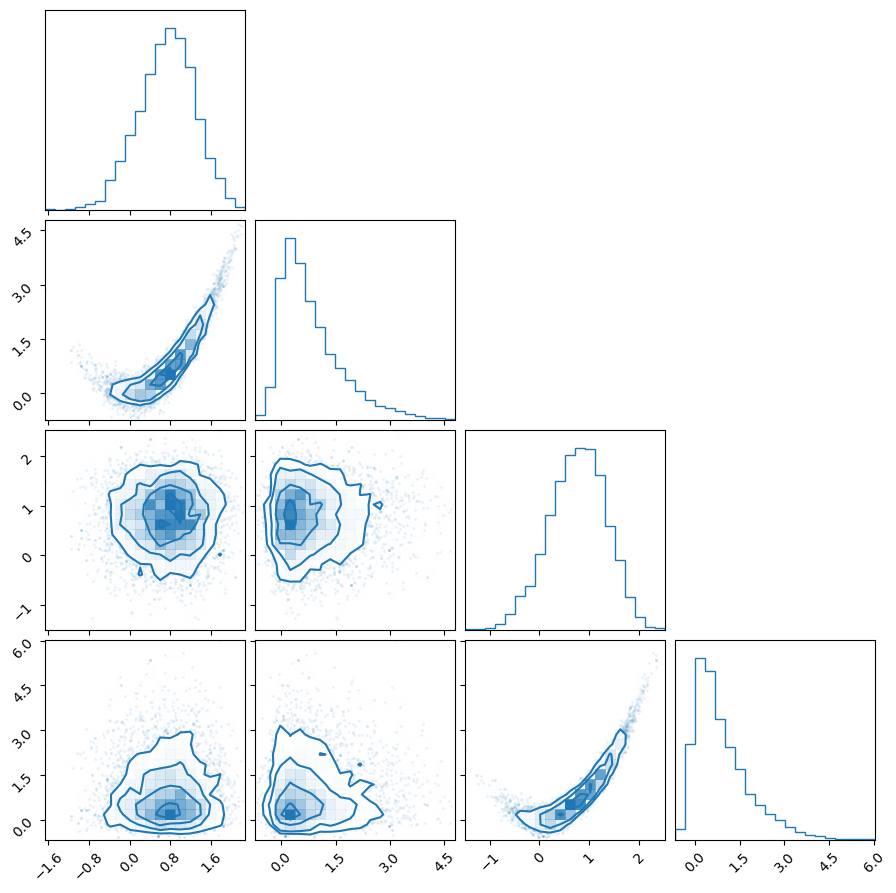

In [ ]:
import matplotlib.pyplot as plt
import corner

# Get the results
samples, weights, logl, logp = sampler.posterior()

# Trace plot for the first 4 parameters
fig = corner.corner(samples[:,:4], weights=weights, color="C0")
plt.show()

### **1.4. Bayesian Model Evidence or Marginal Likelihood**

We can compute the model evidence and its associated uncertainty using the evidence() method.

In [ ]:
# Get the evidence and its uncertainty
logz, logz_err = sampler.evidence()
print("logZ", logz, "+-", logz_err)

logZ -21.457943982256012 +- 0.025631876119399485


---
# **2. LIKELIHOOD EXPLANATION**
---
### **2.1. Standard Case**

For practical purposes it is more convenient to work with the log-likelihood function. This is defined as **log L(θ) = log P(d|θ)**, where **D** are the data and **θ** are the parameters of the model that we are trying to fit to the data. The (log-)likelihood function is not probability density and its specific form depends on the problem. For the vast majority of cases, the likelihood is assumed to be Gaussian.

Suppose that we want our likelihood function to be a Gaussian density with 10 parameters or in 10-D, we would do something like:

In [5]:
import numpy as np

# Define the dimensionality of our problem.
n_dim = 10

# Define our 3-D correlated multivariate normal log-likelihood.
C = np.identity(n_dim)
C[C==0] = 0.95
Cinv = np.linalg.inv(C)
lnorm = -0.5 * (np.log(2 * np.pi) * n_dim + np.log(np.linalg.det(C)))

def log_like(x):
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

The inclusion of the normalisation factor `lnorm` is not strictly necessary as it does not depend on **x** and thus does vary. This is a highly artificial scenario with no data or model. For an example of how to fit a model to some data using a Gaussian likelihood visit the Tutorials section.

### **2.2. Additional arguments**

If the log-likelihood function relies on additional arguments in the sequence `log_likelihood(x, *args, **kwargs)`, then one can use the `likelihood_args` and `likelihood_kwargs` when initializing the sampler to provide them.

In [7]:
def log_likelihood(x, data, sigma, **kwargs):
    sigma_prime = kwargs.get("scale") * sigma
    return -0.5 * np.sum((x - data)**2 / sigma_prime**2)

import pocomc as pc
from scipy.stats import norm

n_dim = 5
prior = pc.Prior(n_dim * [norm(loc=0, scale=10)])

# Random data and sigma values
data = np.random.randn(n_dim)
sigma = np.ones(n_dim)

sampler = pc.Sampler(prior, log_likelihood, likelihood_args=(data, sigma), likelihood_kwargs={"scale": 1.0})

### **2.3. Vectorization**

Sometimes it is possible to define a vectorized log-likelihood function that instead of accepting as input a single set of parameters (i.e., array of shape (n_dim,)) and returning the corresponding scalar value of the natural logarithm of likelihood, it takes as input an array of shape (N, n_dim) and returns an array of shape (N,). pocoMC can take advantage of the vectorization by setting vectorize=True. A simple example for a Gaussian likelihood of zero mean and unit variance is given below:

In [6]:
def log_likelihood(x):
    return -0.5 * np.sum(x**2, axis=1)

import pocomc as pc
from scipy.stats import norm

prior = pc.Prior(5 * [norm(loc=0, scale=10)])

sampler = pc.Sampler(prior, log_likelihood, vectorize=True)

---
# **3. PRIOR PROBABILITY**
---

### Full list of distributions is available [here](https://docs.scipy.org/doc/scipy/reference/stats.html)

### **3.1. Standard priors**

The next step is to define the prior probability distribution. This encodes our knowledge about the parameters of the model before we have seen any data.

`pocoMC` offers two ways to define a prior. The first is to utilise ready-made priors from the scipy.stats package. For instance, if we want our prior to be a uniform distribution on the interval **[-10, 10]** for all 10 of the parameters, we would do:


In [8]:
from scipy.stats import uniform

prior = pc.Prior(n_dim * [uniform(loc=-10.0, scale=20.0)]) # Uniform prior on [-10,10] for all 10 parameters.

Suppose now that we want a different prior for each parameter. For instance, we want the first five parameters to have a flat/uniform prior and the last 5 to have normal prior, then: 

In [ ]:
from scipy.stats import uniform, norm

prior = pc.Prior([uniform(loc=-10.0, scale=20.0), # Uniform prior on [-10,10] for the first parameter.
                  uniform(loc=-10.0, scale=20.0), # Uniform prior on [-10,10] for the second parameter.
                  uniform(loc=-10.0, scale=20.0), # Uniform prior on [-10,10] for the third parameter.
                  uniform(loc=-10.0, scale=20.0), # Uniform prior on [-10,10] for the fourth parameter.
                  uniform(loc=-10.0, scale=20.0), # Uniform prior on [-10,10] for the fifth parameter.
                  norm(loc=0.0, scale=3.0), # Normal prior with mean=0 and std=3 for the sixth parameter.
                  norm(loc=0.0, scale=3.0), # Normal prior with mean=0 and std=3 for the seventh parameter.
                  norm(loc=0.0, scale=3.0), # Normal prior with mean=0 and std=3 for the eighth parameter.
                  norm(loc=0.0, scale=3.0), # Normal prior with mean=0 and std=3 for the ninth parameter.
                  norm(loc=0.0, scale=3.0), # Normal prior with mean=0 and std=3 for the tenth parameter.
                 ])



# or there is a second option
prior = pc.Prior([uniform(loc=-10.0, scale=20.0)] * 5 + [norm(loc=0.0, scale=3.0)] * 5)

### **3.2. Custom priors**

The second way to define a prior is to define a class including the `logpdf` and `rvs` methods and `dim` and `bounds` attributes. This can be useful when the prior has some conditional/hierarchical structure. As an example, let us assume we have a three-parameter model where the prior for the third parameter depends on the values for the first two. This might be the case in, e.g., a hierarchical model where the prior over **c** is a Normal distribution whose mean **m** and standard deviation **s** are determined by a corresponding “hyper-prior”. We can easily set up a prior transform for this model by just going through the variables in order. This would look like:

In [9]:
import numpy as np
from scipy.stats import norm

class CustomPrior:
    def __init__(self):
        self.dim = 3
        self.bounds = np.array([[-np.inf, np.inf],
                                [0.0, 10],
                                [-np.inf, np.inf]])
        self.hyper_mean = 0.0
        self.hyper_std = 3.0

    def logpdf(self, x):
        m, s, c = x
        return norm.logpdf(c, loc=m, scale=s)

    def rvs(self, size=1):
        m = np.random.normal(loc=self.hyper_mean, scale=self.hyper_std, size=size)
        s = np.random.uniform(low=0.0, high=10.0, size=size)
        c = np.random.normal(loc=m, scale=s, size=size)
        return np.array([m, s, c]).T

prior = CustomPrior()

### **3.3. Boundary conditions**

### **By default, pocoMC assumes that all parameters specified in the prior have hard bounds. In other words, each parameter is free to vary in a prespecified range. Anytime a value is proposed by pocoMC that lies outside of this range, it is automatically rejected. This is the desired behavior for most problems, since individual parameters are often either defined everywhere (i.e. from negative infinity to infinity) or over a finite range (e.g., from -1 to +1).**

However, there are problems in which specific parameters may behave differently. pocoMC supports two such cases:

 - **Periodic boundary conditions.** In this case, pocoMC assumes that the parameter is periodic. For example, if the parameter is on the interval `[0, 2*np.pi]`, then the parameter can be wrapped around to the other side of the interval. This can be useful for phase parameters that might be periodic e.g. on a range `[0,2*np.pi]`.
 - **Reflective boundary conditions.** In this case, pocoMC assumes that the parameter is reflective. For example, if the parameter is on the interval [0, 1], then the parameter can be flipped around to the other side of the interval. This can be useful for parameters that are ratios where `a/b` and `b/a` are equivalent.

Given the above, it is possible to set the periodic and reflective attributes of the prior. For example, in a five-parameter model, if we want the first two parameters to be periodic, and the third and fourth to be reflective, we would do: 


In [ ]:
from scipy.stats import uniform, norm

prior = pc.Prior([
    uniform(loc=0.0, scale=2*np.pi), # this parameter is periodic
    uniform(loc=0.0, scale=2*np.pi), # this parameter is periodic
    uniform(loc=0.0, scale=1.0), # this parameter is reflective
    uniform(loc=0.0, scale=1.0), # this parameter is reflective
    norm(loc=0.0, scale=3.0), # this parameter is neither periodic nor reflective
])

sampler = pc.Sampler(prior,
                    #loglike,
                    periodic=[0,1],
                    reflective=[2,3])

---
# **4. SAMPLING**
---

This section explores the various options that are available to the user when it comes to the initialization of the sampler and running the sampler.

### **4.1. Sampler Initialization**

We assume that the user has already defined their prior probability prior and log-likelihood function likelihood, and if the latter requires any additional arguments (e.g., `vectorize`, `likelihood_args`, `likelihood_kwargs`) to provide to the sampler the user has already done it. Please see the relevant sections in the documentation if you have not done so already.

### **4.2. Number of particles**

### **By far, the most important parameters that control the performance of pocoMC are the number of effective and active particles. These are controlled respectively by the parameters ``n_effective`` and ``n_active``**

 - Number of Effective Particles (``n_effective``): Monte Carlo samplers such as pocoMC represent probability distributions as ensembles of particles. **The greater the number of particles, the better the more accurate the representation of the target distribution**. Generally, simpler distributions (i.e., close to Gaussian) require low number of particles, whereas complex distributions (i.e., skewed or multimodal) require large number of particles. Unlike Nested Sampling methods, Preconditioned Monte Carlo, and thus pocoMC, utilize unequally weighted particles with some particles contributing more and some less to the aforementioned representation. As a result, we talk about effective particles. **We recommend values around 500 for most problems and increasing that to 2000-4000 particularly challenging distributions.** If you are not sure about what value to use, do not worry. This can be determined automatically by pocoMC (see the Dynamic Particle Allocation section below). The default value is ``n_effective=512``.

 - Number of Active Particles (``n_active``): pocoMC propages the effective particles from the prior to the posterior through a series of steps or iterations. However, in each iteration, not all effective particles are updated. Instead, only a subset of those, called active particles are updated. Generally, the number of active particles ``n_active`` should be no more than half the number of effective particles ``n_effective`` for best performance. The default value is ``n_active=256``.

Here is an example of how to manually specify the number of effective and active particles. If only one of them is specified and the other is None, then the other is set automatically. 

In [ ]:
sampler = pc.Sampler(prior, log_likelihood, n_effective=1024, n_active=512)

### **4.3. Dynamic particle allocation**

For most applications, the default number of effective and active particles are more than sufficient to guarantee fast and accurate sampling of the posterior distribution. However, there are cases where the difficulty of the target distribution varies during the run. In this case it is beneficial to dynamically adjust the number of effective particles ``n_effective`` automatically (i.e., increase it when the problem becomes more difficult and decrease it when it becomes easier). This dynamic allocation of effective particles is achieved by setting ``dynamic=True`` in the initialization of the sampler. By default, dynamic allocation is turned on.

In [ ]:
sampler = pc.Sampler(prior, log_likelihood, dynamic=True)

### **4.4. MCMC**

``pocoMC`` relies on MCMC methods to diversify the active particles in each iteration. This is the most computationally expensive part of the algorithm and great care has been taken so that it is performed as efficiently as possible.

``pocoM``C supports two different Markov kernels that can be specified using the sample argument:

 - **t-preconditioned Crank-Nicolson** (``sample='tpcn'``): The t-preconditioned Crank-Nicolson (tpCN) MCMC algorithm is an advanced technique designed to improve sampling efficiency in high-dimensional and complex distributions. Unlike traditional methods (e.g, Random-walk Metropolis) where Gaussian perturbations are added directly to the current state, tpCN shifts these perturbations toward higher probability regions, enhancing the algorithm’s scalability to high dimensions. This shift is achieved by combining the current state with a preconditioned perturbation, balancing exploration and stability. The preconditioning step adapts to the structure of the target distribution, ensuring consistent acceptance rates and efficient exploration. Consequently, tpCN provides a robust and effective approach for sampling in high-dimensional spaces, outperforming simpler MCMC methods in such challenging settings.

 - **Random-walk Metropolis** (``sample='rwm'``): The is an MCMC method designed to sample from complex probability distributions. It generates new samples by adding a Gaussian-distributed perturbation to the current state and then accepts or rejects the proposed state based on the Metropolis acceptance criterion, which ensures that the samples converge to the target distribution. Despite its simplicity and broad applicability, the Random-walk Metropolis algorithm scales poorly to high-dimensional spaces. As the dimensionality increases, the probability of accepting proposed moves decreases, leading to inefficient exploration of the target distribution and slow convergence. This makes it less suitable for high-dimensional problems where more sophisticated methods (e.g., t-preconditioned Crank-Nicolson, NUTS, etc.) are often required.

By default, ``sample='tpcn'`` and the t-preconditioned Crank-Nicolson Markov kernel is utilized. The Random-walk Metropolis kernel is only intended to be used for testing.

The purpose of the Markov kernel is to diversify the particles and make the equilibrate in each target distribution. This means that in each iteration we need to ensure that MCMC has ran long enough. To do this, pocoMC monitors the mean (unnormalized) posterior log-probability until it stops increasing for at least **N** steps, where **N** is given by:

N = n_steps * ((2.38/sqrt(n_dim))/proposal scale of tpcn)^2

where ``n_dim`` is the dimensionality of the problem (i.e., number of parameteres) and the proposal scale of tpCN or RWM that is determined adaptively by pocoMC and ``n_steps`` is a hyperparameter. By default, it is equal to the dimensionality of the problem, that is ``n_steps=n_dim``. However, for highly challenging problems, the user can provide a different value. For instance:

In [ ]:
sampler = pc.Sampler(prior, log_likelihood, n_steps=2*n_dim)

### **4.5. Preconditioning**

By default, ``pocoMC`` utilizes a normalizing flow to precondition (i.e., simplify) the target distribution. However, for sufficiently nice distributions that do not deviate significantly from a Gaussian distribution, this procedure may be unnecessary. In these cases, when the posterior is close to a Gaussian distribution and the computational cost of the likelihood is low, one can turn off the preconditioning and avoid training and evaluating the normalizing flow. This can be achieve simply by doing:

In [ ]:
sampler = pc.Sampler(prior, log_likelihood, precondition=False)

### **4.6. Running**

Once the sampler has been configured and initialized, running it in order to sample from the posterior distribution is quite simple. All the user has to do is call the ``run()`` method of the Sampler object. Optionally, there are three parameters that can be adjusted:

 - ``n_total`` This parameter specifies the effective sample size (or unique sample size if ``metric='uss'``) that is required before the sampling terminates. The default value is ``n_total=4096``. This is usually more than enough to construct nice diagrams showing the 1D and 2D marginal posteriors of various parameters. However, for publication purposes one may want to increase ``n_total`` to about ~ 10_000. Similarly, for preliminary runs one can also decrese this (e.g., ``n_total=1024``)

 - ``n_evidence`` This parameter specified the number of samples that will be generated from the normalizing flow at the end of the run to compute the importance sampling estimate of the log model evidence **log(Z)**. Higher values will generally lead to more accurate estimates. If you do not require an estimate of the model evidence, you can set ``n_evidence=0``

 - ``progress`` This is a simple boolean parameter controlling whether or not a progress bar appears during running. By default progress=True.

In [ ]:
sampler.run(
    n_total=4096,
    n_evidence=4096,
    progress=True,
)

### **4.7. Continue Running after Completion**

It is possible to continue running the sampler after sampling has been completed in order to add more samples. This can be useful if the user requires more samples to be able to approximate posterior or estimate the evidence more accurately. This can be achieved easily by calling the ``run()`` method again with higher ``n_total`` and/or ``n_evidence`` values. For instance:

In [ ]:
sampler.run(
    n_total=16384,
    n_evidence=16384,
)

---
# **5. PARALELLIZATION**
---

If you want to run computations in parallel, ``pocoMC`` can use a user-defined pool to execute a variety of expensive operations in parallel rather than in serial. ``pocoMC`` allows for both internal and external parallelization options.

### **5.1. Internal Parallelization**

The simplest way to parallelize ``pocoMC``, especially when running on a single machine (e.g., laptop or single CPU node on an HPC cluster) is to use the internal parallelization offered by ``pocoMC``. This option essentially relies on the multiprocess package to perform the computation of the likelihood function for all active particles in parallel.

To achieve this, the user simply has to provide the desired number of CPU processes. This should not exceed the number of available physical CPUs cores (e.g., 12 for a modern MacBook Pro). The number of processes is provided through the pool argument during the initialization of the sampler class:

In [ ]:
import pocomc as pc

sampler = pc.Sampler(prior, log_likelihood, pool=10) # For 10 parallel processes

### **5.2. External Parallelization**

### For details look [here](https://pocomc.readthedocs.io/en/latest/parallelization.html)



---
# **6. NORMALIZING FLOWS**
---


### **6.1. Normalizing Flow Preconditioning**

The source of the high sampling of efficiency and flexibility of ``pocoMC`` is its advanced preconditioning strategy. Preconditioning is Preconditioning is a technique used to make hard problems easier to solve. The main idea is to transform the original problem into a new one that is easier to solve. When the problem is a sampling problem (e.g., sampling from a probability distribution), preconditioning can be used to transform the original distribution into a new one that is easier to sample from (e.g., a distribution that is closer to the normal distribution).

``pocoMC`` supports a plethora of normalizing flows implemented through the ``zuko`` package. **The user can choose either a predefined flow or define their own flow.**

 - **Masked Autoregressive Flows (MAF)**: Masked Autoregressive Flow (MAF) is a type of normalizing flow that utilizes autoregressive models to parameterize the transformation from a simple base distribution to a more complex target distribution. It achieves this by applying a series of invertible transformations, each conditioned on previous variables in an autoregressive manner. The main advantage of MAF is its ability to efficiently compute the log-likelihood of the transformed data due to its autoregressive structure, which allows for exact likelihood evaluation. This makes MAF particularly useful for density estimation and generative modeling tasks where likelihood-based training is crucial.

 - **Neural Spline Flows (NSF)**: Neural Spline Flow (NSF) extends the concept of normalizing flows by using neural networks to parameterize piecewise monotonic rational quadratic splines as the invertible transformations. These splines provide a flexible way to model complex distributions while ensuring smooth and differentiable transformations. NSF combines the expressive power of neural networks with the efficiency of spline-based transformations, allowing for efficient sampling and exact likelihood computation. This makes NSF particularly effective for modeling high-dimensional data with complex, multimodal distributions, enhancing the flexibility and accuracy of normalizing flow-based generative models.

The predefined MAF and NSF flows are ``'maf3'``, ``'maf6'``, ``'maf12'``, ``'nsf3'``, ``'nsf6'``, and ``'nsf12'``. By default, pocoMC uses the ``'nsf6'`` flow, meaning a Neural Spline Flow with 6 transformations. This balances flexibility and computational cost. The user can change the flow by setting the flow parameter in the pocoMC Sampler class as follows: 


In [ ]:
sampler = pc.Sampler(prior, log_likelihood, flow='maf12')

### **6.2. Custom Flows**

The user can also define their own normalizing flow. This is done by creating a flow using the zuko package and passing it to the Sampler class. For example, the following code creates a MAF flow with 10 transformations, 3-layered neural networks, 128 hidden units per layer, and residual connections between layers:

In [ ]:
import zuko

flow = zuko.flows.MAF(n_dim, # Number of dimensions of the posterior
                      transforms=10, 
                      hidden_features=[128] * 3,
                      residual=True,)

sampler = pc.Sampler(prior, log_likelihood, flow=flow)

### **6.3. Training**

The flow is trained in each iteration of the sampler automatically. The training process is quite quick due to the fact that the flow is not trained from scratch in each iteration, but rather the training is continued from the previous iteration. The user can control the training configuration by passing a dictionary with the desired configuration to the ``train_config`` argument of the ``Sampler`` class. The default configuration is:

In [ ]:
train_config = dict(validation_split=0.5, # Fraction of the data to use for validation
                    epochs=5000, # Maximum number of epochs to train for
                    batch_size=np.minimum(n_effective//2, 512), # Batch size
                    patience=n_dim, # Number of epochs to wait before early stopping
                    learning_rate=1e-3, # Learning rate
                    annealing=False, # Whether to use a learning rate schedule
                    gaussian_scale=None, # Standard deviation of the Gaussian prior on the weights used for regularization
                    laplace_scale=None, # Scale of the Laplace prior on the weights used for regularization
                    noise=None, # Standard deviation of the Gaussian noise added to the input data
                    shuffle=True, # Whether to shuffle the data before training
                    clip_grad_norm=1.0, # Maximum norm of the gradient
                    verbose=0, # Verbosity level
                    )

We do not recommend changing the default training configuration unless you are familiar with the training process and the impact of the hyperparameters on the results. The default configuration is designed to work well for a wide range of problems. If you do want to change the configuration, 
### **We recommend starting with the default values and only changing one hyperparameter at a time.**

### **6.4. Training Frequency**

The normalizing flow is not always trained in every iteration. Instead, this is controlled by the ``train_frequency parameter``. By default, the value of this parameter is ``None`` and the training frequency is determined by the number of effective and active particles respectively as follows:

f = max((n_effective/(2*n_active)), 1)

This means that for the default values ``n_effective=512`` and ``n_active=256``, we train the flow every iteration. However, for larger number of effective particles, or equivalently smaller number of active particles, the normalizing flow is trained more sparsely.

The user can also enter an integer value to ``train_frequency`` to specify exactly how often training occurs. The only exemption is when ``beta=1.0``, when training occurs in every iteration.